In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs 

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [4]:
def recalc_val(save_path):
    net_config_path = save_path + 'net_configs.p'
    state_dict_path = save_path + 'model.pt'
    datasets = [ 
        inputs.Sim1DWalk(num_steps=500, left_right_stay_prob=[5,1,1], num_states=64),
        inputs.Sim2DWalk(num_steps=500, num_states=64),
        inputs.Sim2DLevyFlight(num_steps=500, walls=7)
        ]
    with open(net_config_path, 'rb') as f:
        net_configs = pickle.load(f)
    net = STDP_SR(
        num_states=64, gamma=net_configs['gamma'],
        ca3_kwargs=net_configs['ca3_kwargs']
        )
    net.load_state_dict(torch.load(state_dict_path))
    net.ca3.set_differentiability(False)
    
    criterion = nn.MSELoss(reduction='none')
    errs = []
    with torch.no_grad():
        for dset in datasets:
            dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
            dg_modes = torch.from_numpy(dset.dg_modes.T).float().to(device).unsqueeze(1)
            _, outputs = net(dg_inputs, dg_modes, reset=True)
            est_T = net.ca3.get_T().detach().numpy()
            real_T = net.ca3.get_real_T()
            err = np.mean(np.abs(est_T - real_T))
            errs.append(err)
    return np.mean(err)

In [ ]:
with open("../trained_models/01_tau_gridsearch/results.p", 'rb') as f:
    results = pickle.load(f)

In [5]:
param_regex = 'pos(.*)_neg(.*)'
gridsearch_dir = "../trained_models/01_tau_gridsearch/"
tau_neg_axes = []
tau_pos_axes = []
vals = []
results = {
    'tau_neg_axes': tau_neg_axes,
    'tau_pos_axes': tau_pos_axes,
    'vals': vals
}
for d in os.listdir(gridsearch_dir):
    param_match = re.search(param_regex, d)
    if param_match is None: continue
    tau_neg_axes.append(float(param_match.group(1)))
    tau_pos_axes.append(float(param_match.group(2)))

    try:
        val = recalc_val(gridsearch_dir + d + '/')
    except:
        val = np.nan
    
#     for file in os.listdir(gridsearch_dir + d):
#         if 'tfevents' not in file: continue
#         tfevents_file = gridsearch_dir + d + '/' + file
#         event_acc = EventAccumulator(tfevents_file)
#         event_acc.Reload()
#         val = event_acc.Scalars('loss_train')[-1].value
    vals.append(val)

RuntimeError: svd_cpu: the updating process of SBDSDC did not converge (error: 1)

In [6]:
xs = np.array(results['tau_neg_axes'])
ys = np.array(results['tau_pos_axes'])
xs = np.sort(np.unique(xs))
ys = np.sort(np.unique(ys))

In [7]:
mat = np.zeros((xs.size, ys.size))*np.nan
for tau_neg_ax, tau_pos_ax, val in zip(
    results['tau_neg_axes'], results['tau_pos_axes'], results['vals']
    ):
    x_idx = np.argwhere(xs == tau_neg_ax)[0,0]
    y_idx = np.argwhere(ys == tau_pos_ax)[0,0]
    mat[x_idx][y_idx] = val

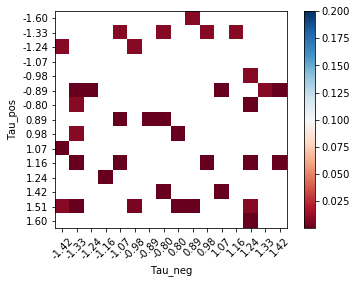

In [8]:
plt.figure()
plt.imshow(mat, cmap="RdBu", vmax=0.2)
plt.yticks(np.arange(xs.size), [f'{x:.2f}' for x in xs])
plt.xticks(
    np.arange(ys.size), [f'{y:.2f}' for y in ys],
    rotation=45
    )
plt.xlabel('Tau_neg')
plt.ylabel('Tau_pos')
plt.colorbar()
plt.show()